# Praktikum AI - RNN
## Komang Niko Romano Prodi
## 222011356 / 3SD1 / 06

## Persiapan

In [ ]:
import pandas as pd 

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


## Baca Data 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/RNN/Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Preprocessing

In [ ]:
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df['text_clean'] = ''
import preprocessor as p
import re

#forming a separate feature for cleaned tweets
for i,v in enumerate(df['text']):
  df.loc[i,'text_clean'] = p.clean(v)

# converting all text to lower case
df['text_clean'] = df['text_clean'].apply(str.lower)

# using regex to remove punctuation
df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [ ]:
df[['text', 'text_clean']]

,text,text_clean
0,@VirginAmerica What @dhepburn said.,what said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...
2,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it
...,...,...
14635,@AmericanAir thank you we got on a different f...,thank you we got on a different flight to chicago
14636,@AmericanAir leaving over 20 minutes Late Flig...,leaving over minutes late flight no warnings o...
14637,@AmericanAir Please bring American Airlines to...,please bring american airlines to
14638,"@AmericanAir you have my money, you change my ...",you have my money you change my flight and don...


In [ ]:
tweets = df[['text_clean','airline_sentiment']]
tweets

,text_clean,airline_sentiment
0,what said,neutral
1,plus youve added commercials to the experience...,positive
2,i didnt today must mean i need to take another...,neutral
3,its really aggressive to blast obnoxious enter...,negative
4,and its a really big bad thing about it,negative
...,...,...
14635,thank you we got on a different flight to chicago,positive
14636,leaving over minutes late flight no warnings o...,negative
14637,please bring american airlines to,neutral
14638,you have my money you change my flight and don...,negative


## Split Data 

In [ ]:
import numpy as np
seed = 43
df_train, df_val, df_test = np.split(tweets.sample(frac=1, random_state=seed), [int(.8*len(tweets)), int(.9*len(tweets))])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11712 entries, 5747 to 10724
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text_clean         11712 non-null  object
 1   airline_sentiment  11712 non-null  object
dtypes: object(2)
memory usage: 274.5+ KB


In [ ]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1464 entries, 2676 to 9289
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text_clean         1464 non-null   object
 1   airline_sentiment  1464 non-null   object
dtypes: object(2)
memory usage: 34.3+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1464 entries, 14343 to 14148
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text_clean         1464 non-null   object
 1   airline_sentiment  1464 non-null   object
dtypes: object(2)
memory usage: 34.3+ KB


In [ ]:
class Vocabulary:
  '''
  __init__ method is called by default as soon as an object of this 
  class is initiated
  we use this method to initiate our vocab dictionaries
  '''
  def __init__(self, freq_threshold, max_size):
    '''
    freq_threshold : the minimum times a word must occur in corpus to 
    be treated in vocab
    max_size : max source vocab size. Eg. if set to 10,000, we pick 
    the top 10,000 most frequent words and discard others
    '''
    #initiate the index to token dict
    ## <PAD> -> padding, used for padding the shorter sentences in a batch to match the length of longest sentence in the batch
    ## <UNK> -> words which are not found in the vocab are replace by this token

    self.itos = {0: '<PAD>', 1: '<UNK>'}
    
    #initiate the token to index dict
    self.stoi = {k:j for j,k in self.itos.items()} 
    self.freq_threshold = freq_threshold
    self.max_size = max_size

  '''
  __len__ is used by dataloader later to create batches
  '''
  def __len__(self):
    return len(self.itos)

  '''
  a simple tokenizer to split on space and converts the sentence to list 
  of words
  '''

  @staticmethod
  def tokenizer(text):
    return [tok.lower().strip() for tok in text.split(' ')]

  '''
  build the vocab: create a dictionary mapping of index to string (itos) 
  and string to index (stoi)
  output ex. for stoi -> {'the':5, 'a':6, 'an':7}
  '''

  def build_vocabulary(self, sentence_list):
    #calculate the frequencies of each word first to remove the words with freq < freq_threshold
    frequencies = {} #init the freq dict
    idx = 4 #index from which we want our dict to start. We already used 4 indexes for pad, start, end, unk

    #calculate freq of words
    for sentence in sentence_list:
      for word in self.tokenizer(sentence):
        if word not in frequencies.keys():
          frequencies[word]=1
        else:
          frequencies[word]+=1

    #limit vocab by removing low freq words
    frequencies = {k:v for k,v in frequencies.items() if v>self.freq_threshold} 

    #limit vocab to the max_size specified
    frequencies = dict(sorted(frequencies.items(), key = lambda x: - x[1])[:self.max_size-idx]) # idx =4 for pad, start, end , unk
    
    #create vocab
    for word in frequencies.keys():
      self.stoi[word] = idx
      self.itos[idx] = word
      idx+=1

  '''
  convert the list of words to a list of corresponding indexes
  '''
  def numericalize(self, text):
    #tokenize text
    tokenized_text = self.tokenizer(text)
    numericalized_text = []

    for token in tokenized_text:
      if token in self.stoi.keys():
        numericalized_text.append(self.stoi[token])
      else: #out-of-vocab words are represented by UNK token index
        numericalized_text.append(self.stoi['<UNK>'])

    return numericalized_text

## Membuat DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [ ]:
class TweetSentimentDataset(Dataset):
  # Static constant variable
  LABEL2INDEX = {'positive': 0, 'neutral': 1, 'negative': 2}
  INDEX2LABEL = {0: 'positive', 1: 'neutral', 2: 'negative'}
  NUM_LABELS = 3

  def load_dataset(self, df): 
    df.columns = ['text_clean','airline_sentiment']

    #print(df)
    df['airline_sentiment'] = df['airline_sentiment'].apply(lambda lab: self.LABEL2INDEX[lab])

    return df

  def __init__(self, df, freq_threshold = 3, vocab_max_size = 10000, *args, **kwargs):
    self.data = self.load_dataset(df)
    self.source_texts = self.data['text_clean'].tolist()
    self.freq_threshold = freq_threshold
    self.vocab_max_size = vocab_max_size
    self.vocab = Vocabulary(freq_threshold, vocab_max_size)
    self.vocab.build_vocabulary(self.source_texts)

  def __getitem__(self, index):
    data = self.data.iloc[index,:]
    text, sentiment = data['text_clean'], data['airline_sentiment']
    token_ids = self.vocab.numericalize(text)
    return torch.tensor(token_ids), torch.tensor(sentiment)

  def __len__(self):
    return len(self.data)

In [ ]:
class MyCollate:
  def __init__(self, pad_idx):
    self.pad_idx = pad_idx
  def __call__(self, batch):
    input_tensors = []
    labels = []
    lengths = []

    for x, y in batch:
      input_tensors.append(x)
      labels.append(y)
      lengths.append(x.shape[0]) #Assume shape is (T, *)

    longest = max(lengths)
    
    if len(input_tensors[0].shape) == 1:
      x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=True, padding_value = self.pad_idx)
    
    else:
      raise Exception('Current implementation only supports (T) shaped data')
      
    y_batched = torch.as_tensor(labels, dtype=torch.long)
    return x_padded, y_batched

In [ ]:
# create Tensor datasets
train_data = TweetSentimentDataset(df_train)
valid_data = TweetSentimentDataset(df_val)
test_data = TweetSentimentDataset(df_test)

In [ ]:
# setting seed
def seed_all(seed):
    if not seed:
        seed = 43

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    numpy.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# setting seed 
import numpy
import random
import torch

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

seed_all(seed)
g = torch.Generator()
g.manual_seed(43)
num_workers = 2

[ Using Seed :  43  ]


In [ ]:
# dataloaders
batch_size = 5

# make sure to SHUFFLE your data
pad_idx = 0

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, 
collate_fn = MyCollate(pad_idx=pad_idx), worker_init_fn=seed_worker, 
generator=g)

valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, 
collate_fn = MyCollate(pad_idx=pad_idx), worker_init_fn=seed_worker, 
generator=g)

test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, 
collate_fn = MyCollate(pad_idx=pad_idx), worker_init_fn=seed_worker, 
generator=g)

In [ ]:
import torch

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.

if is_cuda:
  device = torch.device("cuda")
  print("GPU is available")
else:
  device = torch.device("cpu")
  print("GPU not available, CPU used")

GPU not available, CPU used


## Mendefinisikan Model RNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SentimentRNN(nn.Module):
  def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,output_dim,drop_prob=0.5):
    super(SentimentRNN,self).__init__()
    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.RNN(input_size=embedding_dim,hidden_size=self.hidden_dim, num_layers=no_layers, batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.fc = nn.Linear(self.hidden_dim, output_dim)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self,x):
    batch_size = x.size(0)
    embeds = self.embedding(x)
    rnn_out, hidden = self.rnn(embeds)
    out = self.dropout(hidden.squeeze(0))
    out = self.fc(out)
    output = self.softmax(out)
    return output


In [ ]:
no_layers = 1
vocab_size = len(train_data.vocab) + 2 #extra 2 for padding and unknown
embedding_dim = 64
output_dim = 3
hidden_dim = 256

model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,output_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

SentimentRNN(
  (embedding): Embedding(2956, 64)
  (rnn): RNN(64, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Menghitung Akurasi Validasi 

In [ ]:
import time
start_time = time.time()
epochs = 10
val_accuracies = []

In [ ]:
def compute_accuracy(model, data_loader, device):
  with torch.no_grad():
    correct_pred, num_examples = 0, 0

    for i, (features, targets) in enumerate(data_loader):
      features = features.to(device)
      targets = targets.to(device)

      logits = model(features)
      _, predicted_labels = torch.max(logits, 1)
      num_examples += targets.size(0)
      correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float()/num_examples * 100

with torch.set_grad_enabled(False):
  val_accuracies.append(compute_accuracy(model, valid_loader, device))
  print(f'val accuracy:'
  f'{val_accuracies[-1]:.2f}%')

val accuracy:25.48%


In [ ]:
temp_akurasi = 0.0

for epoch in range(epochs):
  running_loss = 0.0
  model.train()

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)
    model.zero_grad()
    logits = model(inputs)
    loss = criterion(logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    if i % 500 == 499: # print every 500 mini-batches
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
      running_loss = 0.0
  
  with torch.set_grad_enabled(False):
    val_accuracies.append(compute_accuracy(model, valid_loader, device))
  
    print(f'val accuracy:'
    f'{val_accuracies[-1]:.2f}%')
    
  print(f'time elapsed: {(time.time() - start_time)/60:.2f} min')

  if(compute_accuracy(model, valid_loader, device) > temp_akurasi):
    model_terbaik = model
  
  torch.save(model.state_dict(),'model_best_accuracy')


[1,   500] loss: 0.939
[1,  1000] loss: 0.879
[1,  1500] loss: 0.856
[1,  2000] loss: 0.861
val accuracy:58.67%
time elapsed: 1.64 min
[2,   500] loss: 0.841
[2,  1000] loss: 0.867
[2,  1500] loss: 0.867
[2,  2000] loss: 0.891
val accuracy:60.93%
time elapsed: 2.06 min
[3,   500] loss: 0.824
[3,  1000] loss: 0.893
[3,  1500] loss: 0.882
[3,  2000] loss: 0.846
val accuracy:61.89%
time elapsed: 2.47 min
[4,   500] loss: 0.878
[4,  1000] loss: 0.865
[4,  1500] loss: 0.894
[4,  2000] loss: 0.878
val accuracy:61.34%
time elapsed: 2.87 min
[5,   500] loss: 0.855
[5,  1000] loss: 0.845
[5,  1500] loss: 0.843
[5,  2000] loss: 0.849
val accuracy:55.74%
time elapsed: 3.26 min
[6,   500] loss: 0.833
[6,  1000] loss: 0.826
[6,  1500] loss: 0.851
[6,  2000] loss: 0.836
val accuracy:60.86%
time elapsed: 3.67 min
[7,   500] loss: 0.839
[7,  1000] loss: 0.842
[7,  1500] loss: 0.835
[7,  2000] loss: 0.833
val accuracy:61.61%
time elapsed: 4.06 min
[8,   500] loss: 0.837
[8,  1000] loss: 0.834
[8,  1500

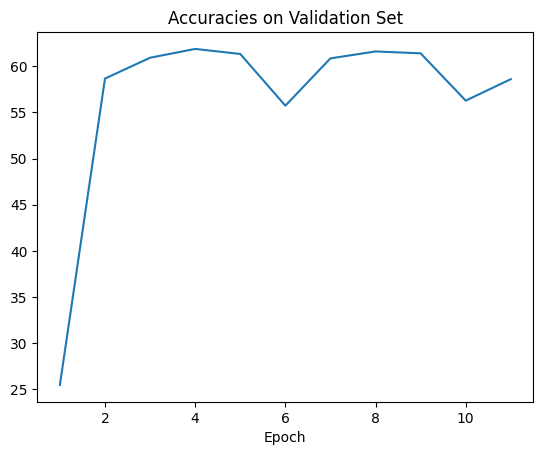

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.xlabel("Epoch")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies)
plt.title("Accuracies on Validation Set")
plt.show()

## Akurasi Testing

In [ ]:
compute_accuracy(model_terbaik, test_loader, device)

tensor(61.7486)

## Graph

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=f22f4f476f9bec21926ec905ef3e99f49e001c53bebc25004fed6b1ed30dd539
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
from torchviz import make_dot
make_dot(logits.mean(), params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'